In [1]:
import numpy as np
import xarray as xr
from scipy.io import loadmat 
import gsw
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
from tqdm.notebook import tqdm
import warnings 
warnings.filterwarnings('ignore')

In [7]:
f_argo_s = '/Users/jakesteinberg/Documents/CPT/Argo/RG_climatology/RG_ArgoClim_Salinity_2019.nc'
f_argo_t = '/Users/jakesteinberg/Documents/CPT/Argo/RG_climatology/RG_ArgoClim_Temperature_2019.nc'
argo_s = xr.open_dataset(f_argo_s,decode_times=False)
argo_t = xr.open_dataset(f_argo_t,decode_times=False)
A_lon = argo_s.LONGITUDE.data
A_lat = argo_s.LATITUDE.data

In [192]:
# ARGO MLD 
f_argo_mld = '/Users/jakesteinberg/Documents/CPT/Argo/Argo_mixedlayers_monthlyclim_12112019.nc'
argo_mld = xr.open_dataset(f_argo_mld)
mld_lon = argo_mld['lon'].data
mld_lat = argo_mld['lat'].data
mld_mo = argo_mld['month'].data
mld = argo_mld['mld_da_mean'].data

In [193]:
np.shape(mld)

(180, 360, 12)

In [5]:
# A_s = argo_s.ARGO_SALINITY_MEAN + argo_s.ARGO_SALINITY_ANOMALY[0]
# A_t = argo_t.ARGO_TEMPERATURE_MEAN + argo_t.ARGO_TEMPERATURE_ANOMALY[0]
Argo_s_clim = np.nan*np.ones((12, np.shape(argo_s.ARGO_SALINITY_ANOMALY[0])[0], \
                              np.shape(argo_s.ARGO_SALINITY_ANOMALY[0])[1], \
                              np.shape(argo_s.ARGO_SALINITY_ANOMALY[0])[2]))
Argo_t_clim = np.nan*np.ones((12, np.shape(argo_s.ARGO_SALINITY_ANOMALY[0])[0], \
                              np.shape(argo_s.ARGO_SALINITY_ANOMALY[0])[1], \
                              np.shape(argo_s.ARGO_SALINITY_ANOMALY[0])[2]))
count = 0
for i in tqdm(np.unique(np.mod(argo_s.ARGO_SALINITY_ANOMALY.TIME.data,12))):
    this_i = np.where(np.mod(argo_s.ARGO_SALINITY_ANOMALY.TIME.data,12) == i)[0]
    Argo_s_clim[count] = argo_s.ARGO_SALINITY_MEAN + np.nanmean(argo_s.ARGO_SALINITY_ANOMALY[this_i],axis=0)
    Argo_t_clim[count] = argo_t.ARGO_TEMPERATURE_MEAN + np.nanmean(argo_t.ARGO_TEMPERATURE_ANOMALY[this_i],axis=0)
    count = count+1

In [6]:
how_deep = 30
density = np.nan * np.ones((12,how_deep,len(A_s.LATITUDE),len(A_s.LONGITUDE)))
for m in range(12):                                 # month 
    for i in tqdm(range(len(A_s.LATITUDE))):        # lat
        for j in range(len(A_s.LONGITUDE)):         # lon
            for k in range(np.shape(density)[1]):   # depth 
                this_p = A_s.PRESSURE[k].data
                this_sa = gsw.SA_from_SP(Argo_s_clim[m,k,i,j].data, \
                                         this_p, A_s.LONGITUDE[j].data, A_s.LATITUDE[i].data)
                this_ct = gsw.CT_from_t(this_sa, Argo_t_clim[m,k,i,j].data, this_p)
                density[m,k,i,j] = gsw.sigma0(this_sa, this_ct)

In [2]:
# save file 
# -------------------------------
filename = ('/Users/jakesteinberg/Documents/CPT/Argo/Argo_potential_density_0_400m.nc')
ds = xr.Dataset(
    data_vars=dict(
        density=(["month","pressure","lat","lon"], density),
    ),
    coords=dict(
        pressure=(["pressure"], A_s.PRESSURE[0:hd_pe].data),
        month=(["month"], np.arange(0,12,1)),
        latitude=(["lat"], A_s.LATITUDE.data),
        longitude=(["lon"], A_s.LONGITUDE.data),
    ),
)
ds.to_netcdf(path=filename)

NameError: name 'density' is not defined

In [2]:
# load file 
filename = ('/Users/jakesteinberg/Documents/CPT/Argo/Argo_potential_density_0_400m.nc')
argo_rho = xr.open_dataset(filename)
density = argo_rho['density'].data
lon = argo_rho.lon.longitude.data
lat = argo_rho.lat.latitude.data
pressure = argo_rho.pressure.pressure.data

# Argo Climatology (mean seasonal cycle from a ten year time series) 

- compute potential density profiles (0-400m) (referenced to the surface)

$P = - \frac{1}{2}g \int \int \int \frac{\left( \rho - \overline{\rho} \right)^2}{\partial \overline{\rho}/dz} dx dy dz $ ("New Estimates of the Available Potential Energy in the World Ocean" Oort et al. 1989)

### reference profile; easiest is to take a global mean profile
* because this definition uses the square of the density anomaly, low density shallow mixed layers in the western equatorial pacific dominate the PE Map 
* this is a globally defined quantity...distinct from seasonally available PE in the mixed layer
* could define using a local time mean (and still calculate the same way) 

### can adapt this to only calculate PE within the mixed layer (need a MLD criteria...but still a background profile)

In [3]:
# USE MIXED LAYER CLIMATOLOGY TO ASK DEPTHS OVER WHICH TO INTEGRATE
f_argo_mld = '/Users/jakesteinberg/Documents/CPT/Argo/Argo_mixedlayers_monthlyclim_12112019.nc'
argo_mld = xr.open_dataset(f_argo_mld)
mld_lon = argo_mld['lon'].data + 200
iinn = np.where((argo_mld['lat'].data >= np.nanmin(lat)) & \
         (argo_mld['lat'].data <= np.nanmax(lat)))[0]
mld_lat = argo_mld['lat'].data[iinn]
mld_offset = np.where(argo_mld['lon'].data >= lon[0])[0][0]
mld = argo_mld['mld_da_mean'].data[iinn]
mld = np.concatenate((mld[:,mld_offset:,:], mld[:,0:mld_offset,:]),axis=1)

In [182]:
how_deep = 30
hd_pe = 30 # decide to what depth we want to integrate PE  
# dz = (-1*A_s.PRESSURE[0:hd_pe-1].data) - (-1*A_s.PRESSURE[1:hd_pe].data)
# dz = np.concatenate((np.array([1*A_s.PRESSURE[0].data]), dz))
dz = (-1*pressure[0:hd_pe-1]) - (-1*pressure[1:hd_pe])
dz = np.concatenate((np.array([1*pressure[0]]), dz))
# -- global mean profile
rho_bar = np.nanmean(np.nanmean( np.nanmean(density,axis=0), axis=1),axis=1)  
# ###### rho_bar_star = np.nanmean(density,axis=0) # mean at one depth 
# -- density anomaly [month, depth, lat, lon]
rho_pr = density - np.tile(rho_bar[None,:,None,None], (12, 1, np.shape(density)[2], np.shape(density)[3]))   
# -- vertical density gradient 
drho_dz = np.nan*np.ones(np.shape(rho_bar))
# drho_dz[1:-1] = (rho_bar[0:-2] - rho_bar[2:])/(-1*(A_s.PRESSURE[0:how_deep-2].data - A_s.PRESSURE[2:how_deep].data))
drho_dz[1:-1] = (rho_bar[0:-2] - rho_bar[2:])/(-1*(pressure[0:how_deep-2] - pressure[2:how_deep]))
drho_dz_map = np.tile(drho_dz[None,:,None,None],(12, 1,np.shape(density)[2], np.shape(density)[3]))
# -- APE 
pe = np.nan * np.ones((12, len(lat), len(lon)))
pe_loc_0 = np.nan * np.ones((12, len(lat), len(lon)))
pe_loc = np.nan * np.ones((12, len(lat), len(lon)))
for i in tqdm(range(np.shape(rho_pr)[0])): # month
    for j in range(np.shape(rho_pr)[2]): # lat
        for k in range(np.shape(rho_pr)[3]): # lon 
            this_mld_z = -1*mld[j,k,i]               # mld of this month
            max_mld_z = -1*np.nanmax(mld[j,k,:])     # deepest mld 
            this_z = gsw.z_from_p(pressure[0:hd_pe],lat[j])
            
            # find deepest z index to start integrating over 
            deep = np.where(this_z <= this_mld_z)[0]
            if max_mld_z < np.nanmin(this_z):
                deep_del = np.array([len(this_z)-1])
            elif max_mld_z > this_z[1]:
                deep_del = np.array([2])
            else:
                deep_del = np.where(this_z <= max_mld_z)[0]
            
            # GLOBAL PE 
            # ----------------------------------------------------------------------    
            if len(deep) > 0:
                deep = deep[0]
                dz = (-1*pressure[0:deep-1]) - (-1*pressure[1:deep])
                dz = np.concatenate((np.array([1*pressure[0]]), dz))
                # -- PE referenced to a global mean density profile and N^2 profile 
                pe[i,j,k] = np.nansum((-0.5*9.81*(rho_pr[i,0:deep,j,k]**2)/drho_dz_map[i, 0:deep,j,k])*dz)
            # LOCAL PE 
            # ----------------------------------------------------------------------
            if len(deep_del) > 0: 
                dz2 = (-1*pressure[0:deep_del[0]-1]) - (-1*pressure[1:deep_del[0]])
                dz2 = np.concatenate((np.array([1*pressure[0]]), dz2))
                # - density anomaly relative to profile associated with deepest MLD 
                rho_pr_loc = (density[i,0:deep_del[0],j,k] - \
                    density[np.where(mld[j,k,:] == np.nanmax(mld[j,k,:]))[0],0:deep_del[0],j,k]) 
                # - denominator 
                rho_bar_loc = np.nanmean(density[:,0:deep_del[0],j,k],axis=0)
                drho_bar_dz_loc = np.nan*np.ones(np.shape(rho_bar_loc))
                drho_bar_dz_loc[1:-1] = (rho_bar_loc[0:-2] - rho_bar_loc[2:])/(-1*(pressure[0:deep_del[0]-2] - pressure[2:deep_del[0]]))
                drho_bar_dz_loc[0] = (rho_bar_loc[0] - rho_bar_loc[1])/(-1*(pressure[0] - pressure[1]))
                # - allow vertical density gradient to vary 
                pe_loc_0[i,j,k] = np.nansum((-0.5*9.81*(rho_pr_loc[0,:]**2)/drho_bar_dz_loc)*dz2)
                # - Sylvia's suggestion: N_0, rho_0 are constants 
                rho_0 = 1025
                N_0_2 = (-9.81/rho_0)*np.nanmean(drho_dz[0:10])
                pe_loc[i,j,k] = np.nansum((0.5*(9.81**2)*(rho_pr_loc[0,:]**2)/(rho_0*N_0_2))*dz2)

                
# pe = np.nansum((-0.5*9.81*(rho_pr[:,0:hd_pe]**2)/drho_dz_map[:, 0:hd_pe])*\
#                np.tile(dz[None,:,None,None],(12,1,np.shape(density)[2], np.shape(density)[3])),axis=1)

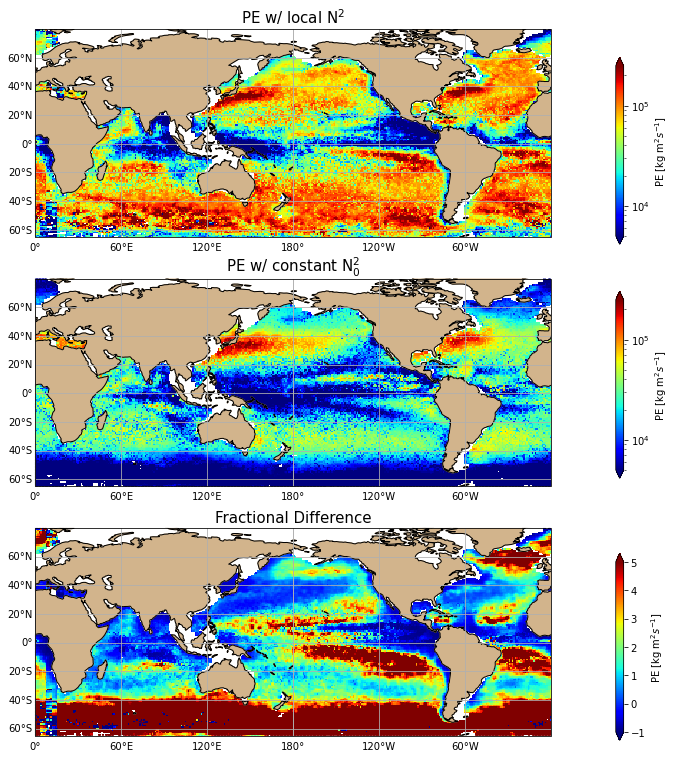

In [191]:
# COMPARE PE LOC ESTIMATES 
data_coords = {'latitude': lat, 'longitude': lon}
pe_levs = [5000, 250000] # 250000
f, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(11,13), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
arg_d = xr.DataArray(data=np.nanmax(pe_loc_0,axis=0), dims=['latitude', 'longitude'], coords=data_coords) 
arg_d_p = arg_d.plot(ax=ax1,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1]), \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False) # norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1])
ax1.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax1.coastlines()
gl = ax1.gridlines(draw_labels=True)
ax1.set_title('PE w/ local N$^2$',fontsize=15)
gl.xlabels_top = False
cbpos = [0.92, 0.4, 0.01, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', label='PE [kg m$^2$$s^{-1}$]')

arg_d = xr.DataArray(data=np.nanmax(pe_loc,axis=0), dims=['latitude', 'longitude'], coords=data_coords) 
arg_d_p = arg_d.plot(ax=ax2,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1]), \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False) # norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1])
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax2.coastlines()
gl = ax2.gridlines(draw_labels=True)
ax2.set_title('PE w/ constant N$_0^2$',fontsize=15)
gl.xlabels_top = False
cbpos = [0.92, 0.65, 0.01, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', label='PE [kg m$^2$$s^{-1}$]')

arg_d = xr.DataArray(data=(np.nanmax(pe_loc_0,axis=0) - np.nanmax(pe_loc,axis=0))/np.nanmax(pe_loc,axis=0), \
                     dims=['latitude', 'longitude'], coords=data_coords) 
arg_d_p = arg_d.plot(ax=ax3,transform=ccrs.PlateCarree(), vmin=-1, vmax=5, \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False) # norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1])
ax3.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax3.coastlines()
gl = ax3.gridlines(draw_labels=True)
ax3.set_title('Fractional Difference',fontsize=15)
gl.xlabels_top = False
cbpos = [0.92, 0.12, 0.01, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', label='PE [kg m$^2$$s^{-1}$]')
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_mean_pe.jpg', dpi=550)

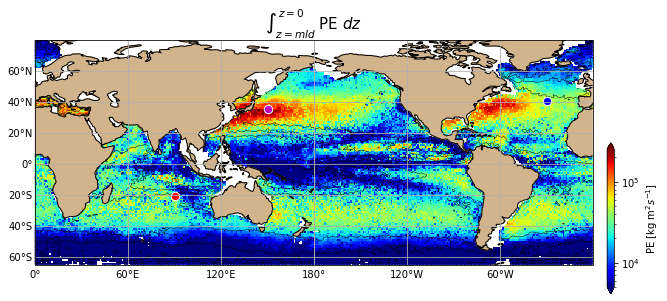

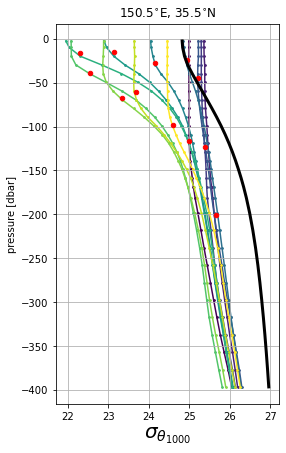

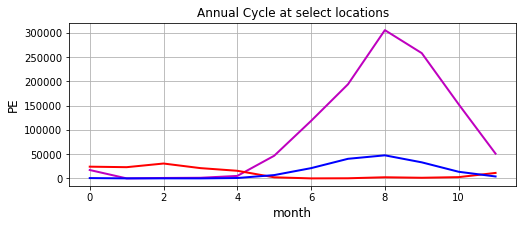

In [36]:
# -- kuroshio
t_lat = 35.5
t_lon = 150.5 
# -- western eq pac 
# t_lat = 10.5
# t_lon = 150.5 
# -- ne pac.
# t_lat = 40.5
# t_lon = 190.5 
# -- site 2 
t_lat_2 = -20.5
t_lon_2 = 90.5 
# -- site 3 
t_lat_3 = 40.5
t_lon_3 = 330.5 

data_coords = {'latitude': lat, 'longitude': lon}
pe_levs = [5000, 250000] # 250000

# FIGURE 1 (map of mean PE)
f, ax = plt.subplots(1,1,figsize=(10,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
arg_d = xr.DataArray(data=np.nanmax(pe_loc,axis=0), dims=['latitude', 'longitude'], coords=data_coords)
arg_d_p = arg_d.plot(ax=ax,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1]), \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False)
ax.contour(lon,lat,np.nanmean(pe,axis=0),\
           colors='k',transform=ccrs.PlateCarree(),levels=np.arange(pe_levs[0],pe_levs[1],75000),linewidths=0.5)
ax.scatter(t_lon - 360,t_lat, s=70,color='m',transform=ccrs.PlateCarree(),zorder=2,edgecolors='w')
ax.scatter(t_lon_2, t_lat_2, s=70,color='r',transform=ccrs.PlateCarree(),zorder=2,edgecolors='w')
ax.scatter(t_lon_3, t_lat_3, s=70,color='b',transform=ccrs.PlateCarree(),zorder=2,edgecolors='w')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
ax.set_title('$\int_{z=mld}^{z=0}$ PE $dz$',fontsize=15)
gl.xlabels_top = False
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, \
                orientation='vertical', extend='both', \
                label='PE [kg m$^2$$s^{-1}$]')
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_mean_pe.jpg', dpi=550)

# FIGURE 2 (12 monthly profiles at one select location)
c_eta = plt.get_cmap('viridis',12)
f, ax = plt.subplots(1,1,figsize=(4,7))
for i in range(12):
    this_z = gsw.z_from_p(pressure,t_lat)
    this_lon = np.where((A_lon > (t_lon-0.5)) & (A_lon < (t_lon+0.5)))[0][0]
    this_lat = np.where((A_lat > (t_lat-0.5)) & (A_lat < (t_lat+0.5)))[0][0]
    ax.plot(density[i, :, this_lat, this_lon], this_z[0:how_deep], color=c_eta(i),zorder=0)
    ax.scatter(density[i, :, this_lat, this_lon], this_z[0:how_deep],s=3, color=c_eta(i),zorder=1)
    int_z = -1*mld[this_lat,this_lon,i]
    deep = np.where(this_z <= int_z)[0]
    if len(deep) > 0:
        ax.scatter(density[i, deep[0], this_lat, this_lon],int_z,s=20, color='r',zorder=2)
ax.plot(np.nanmean(np.nanmean( np.nanmean(density,axis=0) ,axis=1),axis=1), this_z[0:how_deep], \
        color='k',linewidth=3)
ax.set_ylabel('pressure [dbar]')
ax.set_xlabel(r'$\sigma_{\theta_{1000}}$',fontsize=20)
ax.set_title(str(t_lon)+'$^{\circ}$E, ' + str(t_lat) + '$^{\circ}$N')
ax.grid()
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_pe_1loc.jpg', dpi=550)

f, ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(pe_loc[:, np.where((A_lat > (t_lat-0.5)) & (A_lat < (t_lat+0.5)))[0][0], \
           np.where((A_lon > (t_lon-0.5)) & (A_lon < (t_lon+0.5)))[0][0]], color='m',linewidth=2)
ax.plot(pe_loc[:, np.where((A_lat > (t_lat_2-0.5)) & (A_lat < (t_lat_2+0.5)))[0][0], \
           np.where((A_lon > (t_lon_2-0.5)) & (A_lon < (t_lon_2+0.5)))[0][0]], color='r',linewidth=2)
ax.plot(pe_loc[:, np.where((A_lat > (t_lat_3-0.5)) & (A_lat < (t_lat_3+0.5)))[0][0], \
           np.where((A_lon > (t_lon_3-0.5)) & (A_lon < (t_lon_3+0.5)))[0][0]], color='b',linewidth=2)
ax.set_xlabel('month',fontsize=12)
ax.set_ylabel('PE',fontsize=12)
ax.set_title('Annual Cycle at select locations',fontsize=12)
ax.grid()
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_seasonal_site_pe.jpg', dpi=550)

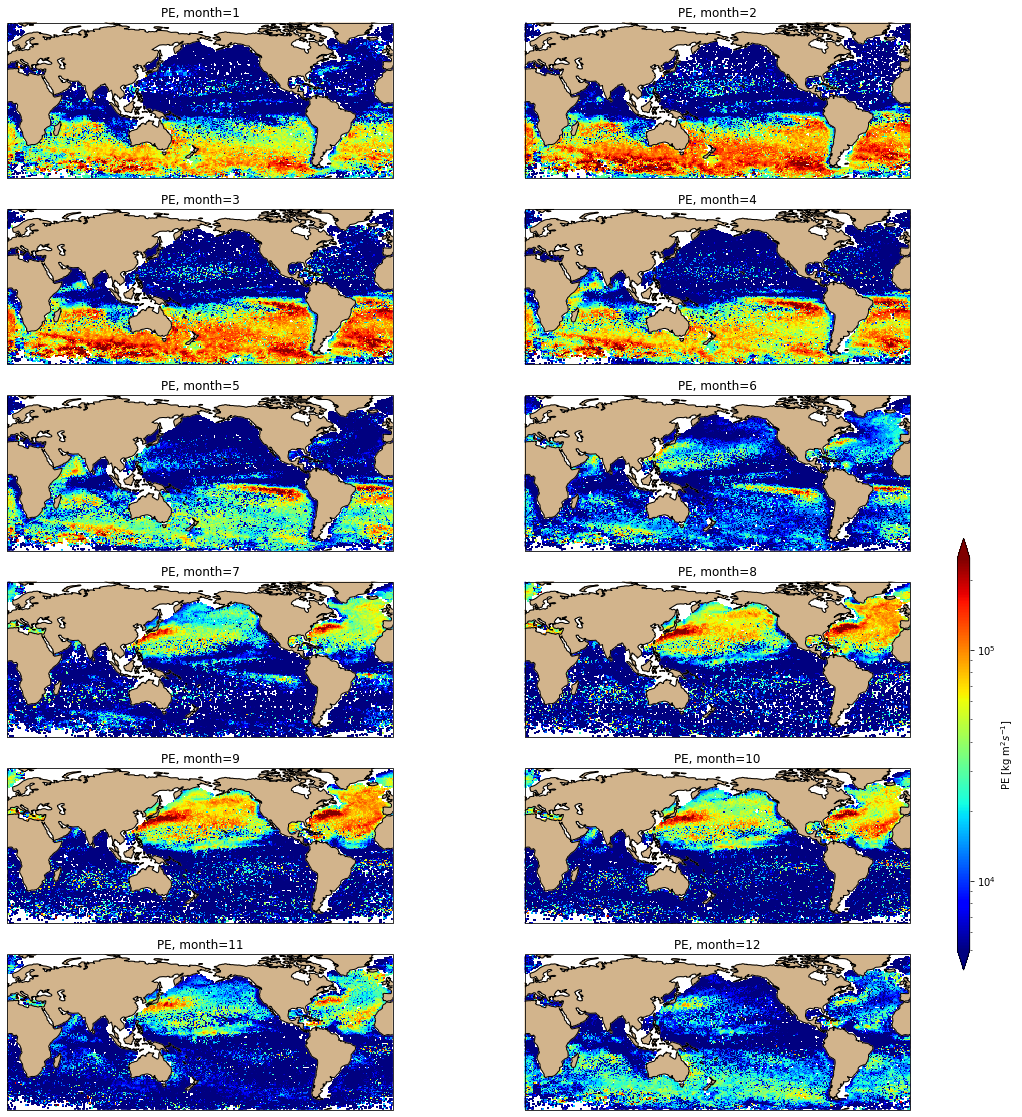

In [323]:
data_coords = {'latitude': lat, 'longitude': lon}
tcmap_2 = plt.get_cmap('jet')
f, ax = plt.subplots(6,2,figsize=(17,20), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
gax = ax.flatten()
for i in range(len(gax)):
    arg_d = xr.DataArray(data=pe_loc[i,:,:], dims=['latitude', 'longitude'], coords=data_coords)
    arg_d_p = arg_d.plot(ax=gax[i],transform=ccrs.PlateCarree(), norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1]), \
                     cmap=tcmap_2, zorder=0, add_colorbar=False)

    gax[i].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    gax[i].coastlines()
    gax[i].set_title('PE, month=' + str(i+1))
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, \
                orientation='vertical', extend='both', \
                label='PE [kg m$^2$$s^{-1}$]') # 'density at ' + str(A_s.PRESSURE[this_p].data) + ' dbar'
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_seasonal_pe.jpg', dpi=550)

In [324]:
# seasonal swing
frac_change = np.nan*np.ones((len(A_s.LATITUDE),len(A_s.LONGITUDE)))
tot_change = np.nan*np.ones((len(A_s.LATITUDE),len(A_s.LONGITUDE)))
for i in tqdm(range(len(A_s.LATITUDE))):        
    for j in range(len(A_s.LONGITUDE)): 
        # if np.nanmean(pe[:,i,j]) > 0.25*np.nanmean(pe):
        tot_change[i,j] = np.abs((np.nanmax(pe[:,i,j]) - np.nanmin(pe[:,i,j]))) # /np.abs(np.nanmean(pe[:,i,j]))
        frac_change[i,j] = np.abs((np.nanmax(pe[:,i,j]) - np.nanmin(pe[:,i,j])))/np.abs(np.nanmean(pe[:,i,j]))


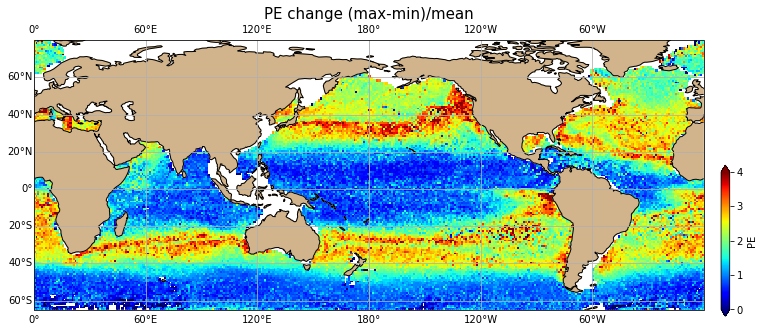

In [328]:
f, ax = plt.subplots(1,1,figsize=(12,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
arg_d = xr.DataArray(data=frac_change, dims=['latitude', 'longitude'], coords=data_coords)
arg_d_p = arg_d.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=0, vmax=4, \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False)
ax.contour(A_s.LONGITUDE.data,A_s.LATITUDE.data,frac_change,\
           colors='k',transform=ccrs.PlateCarree(),\
           levels=np.arange(pe_levs[0],pe_levs[1],50000),linewidths=0.5) # np.nanmean(pe,axis=0)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title('PE change (max-min)/mean',fontsize=15)
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', \
                label='PE')
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_seasonal_frac_change.jpg', dpi=550)

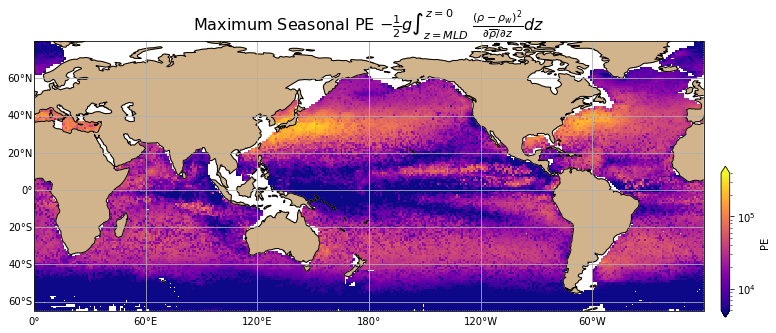

In [37]:
max_loc_pe = np.nan*np.ones((np.shape(pe_loc)[1], np.shape(pe_loc)[2]))
max_loc_pe_mo = np.nan*np.ones((np.shape(pe_loc)[1], np.shape(pe_loc)[2]))
for i in range(np.shape(pe_loc)[1]):
    for j in range(np.shape(pe_loc)[2]):
        max_loc_pe[i,j] = np.nanmax(pe_loc[:,i,j])
        if (~np.isnan(np.nanmax(pe_loc[:,i,j]))) & (np.nanmax(pe_loc[:,i,j]) > 0):
            max_loc_pe_mo[i,j] = np.where(pe_loc[:,i,j] == np.nanmax(pe_loc[:,i,j]))[0]
        
f, ax = plt.subplots(1,1,figsize=(12,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
arg_d = xr.DataArray(data=max_loc_pe, dims=['latitude', 'longitude'], coords=data_coords)
arg_d_p = arg_d.plot(ax=ax,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=pe_levs[0], vmax=400000), \
                     cmap=plt.get_cmap('plasma'), zorder=0, add_colorbar=False)
# ax.contour(A_s.LONGITUDE.data,A_s.LATITUDE.data,np.nanmean(pe,axis=0),\
#            transform=ccrs.PlateCarree(),\
#            levels=np.arange(pe_levs[0],pe_levs[1],25000),linewidths=0.75,colors='w') # np.nanmean(pe,axis=0)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
ax.set_title(r'Maximum Seasonal PE $- \frac{1}{2} g \int_{z=MLD}^{z=0}$ $\frac{(\rho-\rho_{w})^2}{\partial \overline{\rho} / \partial z} dz$',fontsize=16)
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both',label='PE')
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_seasonal_frac_change.jpg', dpi=550)

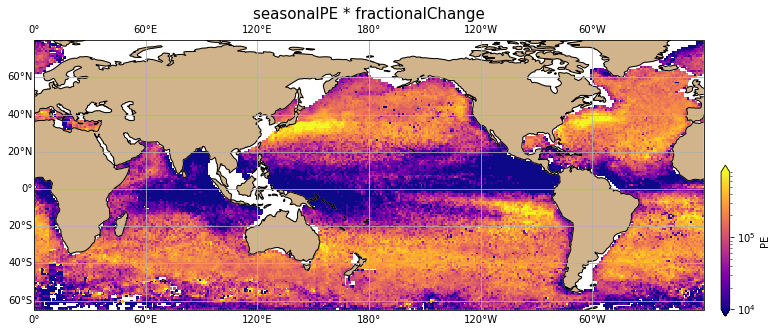

In [343]:
# (vmin=100000000, vmax=100000000000)
f, ax = plt.subplots(1,1,figsize=(12,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
arg_d = xr.DataArray(data=max_loc_pe*frac_change, dims=['latitude', 'longitude'], coords=data_coords)
arg_d_p = arg_d.plot(ax=ax,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=10000, vmax=800000), \
                     cmap=plt.get_cmap('plasma'), zorder=0, add_colorbar=False)
# ax.contour(A_s.LONGITUDE.data,A_s.LATITUDE.data,frac_change,\
#            colors='k',transform=ccrs.PlateCarree(),\
#            levels=np.arange(pe_levs[0],pe_levs[1],50000),linewidths=0.5) # np.nanmean(pe,axis=0)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title('seasonalPE * fractionalChange',fontsize=15)
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', \
                label='PE')
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_seasonal_frac_change.jpg', dpi=550)

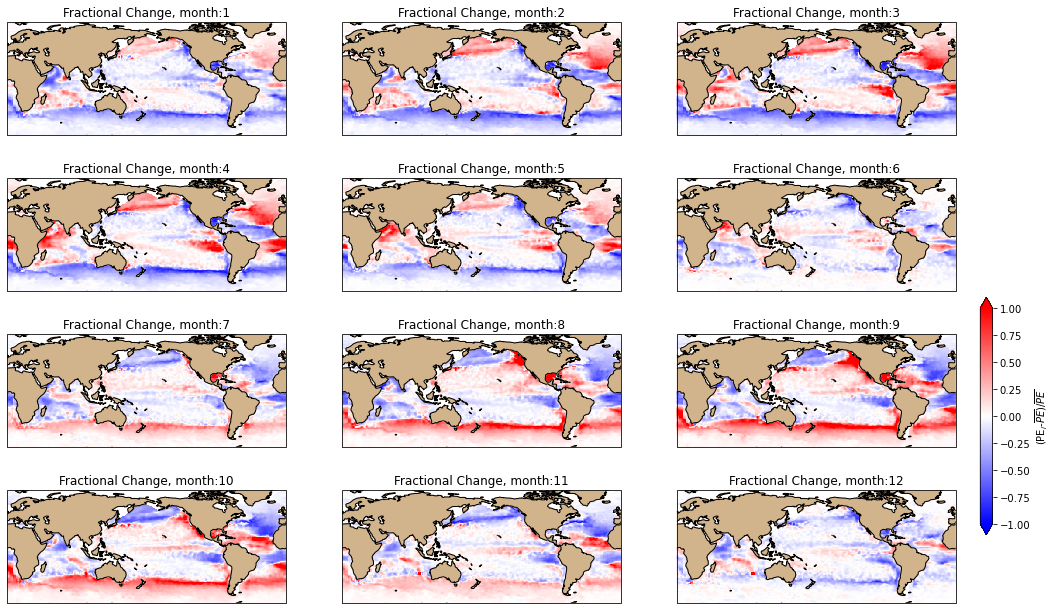

In [26]:
data_coords = {'latitude': A_s.LATITUDE.data, 'longitude': A_s.LONGITUDE.data}
tcmap_2 = plt.get_cmap('bwr')
f, ax = plt.subplots(4,3,figsize=(17,11), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
gax = ax.flatten()
for i in range(len(gax)):
    arg_d = xr.DataArray(data=(pe[i,:,:]-np.nanmean(pe,axis=0))/np.nanmean(pe,axis=0), \
                         dims=['latitude', 'longitude'], coords=data_coords)
    arg_d_p = arg_d.plot(ax=gax[i],transform=ccrs.PlateCarree(), vmin=-1, vmax=1, \
                     cmap=tcmap_2, zorder=0, add_colorbar=False)

    gax[i].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    gax[i].coastlines()
    gax[i].set_title('Fractional Change, month:' + str(i+1))
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, \
                orientation='vertical', extend='both', \
                label='(PE$_i$-$\overline{PE}$)/$\overline{PE}$') # 'density at ' + str(A_s.PRESSURE[this_p].data) + ' dbar'
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_seasonal_pe.jpg', dpi=550)

In [ ]:
# ----- APE AND RATE OF CONVERSION TO EKE ------ 
# try estimate availbe potential energy 
# APE extracted from the mean state at rate = 
# dP/dt = - \int \int \int g*kGM*abs(hor grad rho)^2 / (drho/dz) dV 
# Vertical Eddy Energy Fluxes in the North Atlantic Subtropical and Subpolar Gyres, Zhai et. al 2013

In [51]:
g = 9.81
rho_0 = 1035
K = loadmat('/Users/jakesteinberg/Documents/CPT/Argo/WOA18_K_v2.mat')
K_lon = K['lon'][0]
K_lat = K['lat'][0]
K_dep = K['depth'][0]
K_K = K['K']
# align in lon, cut off in lat, interpolate to right depth 
iinn = np.where((K_lat >= np.nanmin(lat)) & (K_lat <= np.nanmax(lat)))[0]
K_K = K_K[:,iinn,:]
K_offset = np.where(K_lon >= lon[0])[0][0]
K_K = np.concatenate((K_K[K_offset:,:,:], K_K[0:K_offset,:,:]),axis=0)

In [116]:
mean_den_r = np.nanmean(density,axis=0)
ape_rate = np.nan*np.ones((np.shape(density)[0], np.shape(density)[2], np.shape(density)[3]))
ape_rate_bfk = np.nan*np.ones((np.shape(density)[0], np.shape(density)[2], np.shape(density)[3]))
# gradx = np.nan*np.ones((np.shape(density)[0], np.shape(density)[2], np.shape(density)[3]))
# grady = np.nan*np.ones((np.shape(density)[0], np.shape(density)[2], np.shape(density)[3]))
for m in tqdm(range(np.shape(density)[0])): # MONTH
    for i in range(5,140): # LAT
        for j in range(5,355): # LON
            # --- drho_dz 
            # this_den = density[m,:,i,j]
            # this_mean_den = np.nanmean(density[:,:,i,j],axis=0)
            this_mean_den = density[m,:,i,j]
            this_z = gsw.z_from_p(pressure,lat[i])
            dz = (this_z[0:-1] - this_z[1:])
            # dz = np.concatenate((np.array([pressure[0]]), dz))
            this_drhodz = (this_mean_den[0:-1] - this_mean_den[1:])/(this_z[0:-1]-this_z[1:])
            # --- drho_dx,drho_dy
            xx = 1852 * 60 * np.cos(np.deg2rad(lat[i])) * (lon[j-2:j+3] - lon[j])
            yy = 1852 * 60 * (lat[i-2:i+3] - lat[i])
            this_drhodx = np.nan*np.ones(len(this_z))
            this_drhody = np.nan*np.ones(len(this_z))
            for zi in range(len(this_z)):
                p1 = np.polyfit(yy, density[m, zi, i-2:i+3, j], 1)
                this_drhody[zi] = p1[0]
                p2 = np.polyfit(xx, density[m, zi, i, j-2:j+3], 1)
                this_drhodx[zi] = p2[0]
            # --- K at right depth 
            this_z_2 = this_z[0:-1] - dz/2
            
            this_gradx = np.interp(np.abs(this_z_2), np.abs(this_z), this_drhodx)
            this_grady = np.interp(np.abs(this_z_2), np.abs(this_z), this_drhody)
            # this_K = np.interp(np.abs(this_z_2), K_dep[0:40], K_K[j,i,0:40])
            this_K = 1000
            # gradx[m,i,j] = this_drhodx[10]
            # grady[m,i,j] = this_drhody[10]
            ape_rate[m,i,j] = np.sum(-1*g*this_K*(this_gradx**2 + this_grady**2)/this_drhodz*dz)
            # np.sum(-1*g*this_K*(np.abs(this_gradx+this_grady)**2)/this_drhodz*dz)
            
            # C = 2
            # omega = 7.292115*10**(-5) # rad/s 
            # f_ref = 2*omega*np.sin(np.deg2rad(lat[i]))
            # H = mld[i,j,m]
            # this_by = np.nan*np.ones(len(this_z))
            # this_bx = np.nan*np.ones(len(this_z))
            # for zi in range(len(this_z)):
            #     p1 = np.polyfit(yy, -g*(1000+density[m, zi, i-3:i+4, j])/rho_0, 1)
            #     this_by[zi] = p1[0]
            #     p2 = np.polyfit(xx, -g*(1000+density[m, zi, i, j-3:j+4])/rho_0, 1)
            #     this_bx[zi] = p2[0]
            # b_y = np.nanmean(this_by)
            # b_x = np.nanmean(this_bx)
            # ape_rate_bfk[m,i,j] = H*()

(-2.0, 5.0)

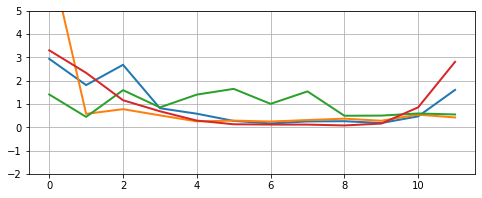

In [117]:
t_lat = [25.5, 35.5, -20.5, 30.5]
t_lon = [150.5, 215.5, 90.5, 310.5]
f, ax = plt.subplots(1,1,figsize=(8,3))
for i in range(len(t_lat)):
    ax.plot(ape_rate[:, np.where((A_lat > (t_lat[i]-0.5)) & (A_lat < (t_lat[i]+0.5)))[0][0], \
                     np.where((A_lon > (t_lon[i]-0.5)) & (A_lon < (t_lon[i]+0.5)))[0][0]]/ \
                     np.nanmean(ape_rate[:, np.where((A_lat > (t_lat[i]-0.5)) & (A_lat < (t_lat[i]+0.5)))[0][0], \
                     np.where((A_lon > (t_lon[i]-0.5)) & (A_lon < (t_lon[i]+0.5)))[0][0]]),linewidth=2)
ax.grid()
ax.set_ylim([-2, 5])

In [164]:
ape_rate_max_month = np.nan*np.ones((np.shape(ape_rate)[1], np.shape(ape_rate)[2]))
ape_rate_max_month_i = np.nan*np.ones((np.shape(ape_rate)[1], np.shape(ape_rate)[2]))
for i in tqdm(range(np.shape(ape_rate)[1])):
    for j in range(np.shape(ape_rate)[2]):
        ape_rate_max_month[i,j] = np.nanmax(ape_rate[:,i,j])
        if np.nansum(ape_rate[:,i,j] < 4):
            ape_rate_max_month_i[i,j] = np.where(ape_rate[:,i,j] == np.nanmax(ape_rate[:,i,j]))[0]

In [203]:
mld_max_month = np.nan*np.ones((np.shape(mld)[0], np.shape(mld)[1]))
for i in tqdm(range(np.shape(mld)[0])):
    for j in range(np.shape(mld)[1]):
        if np.nansum(np.isnan(mld[i,j,:])) < 4:
            mld_max_month[i,j] = np.where(mld[i,j,:] == np.nanmax(mld[i,j,:]))[0]

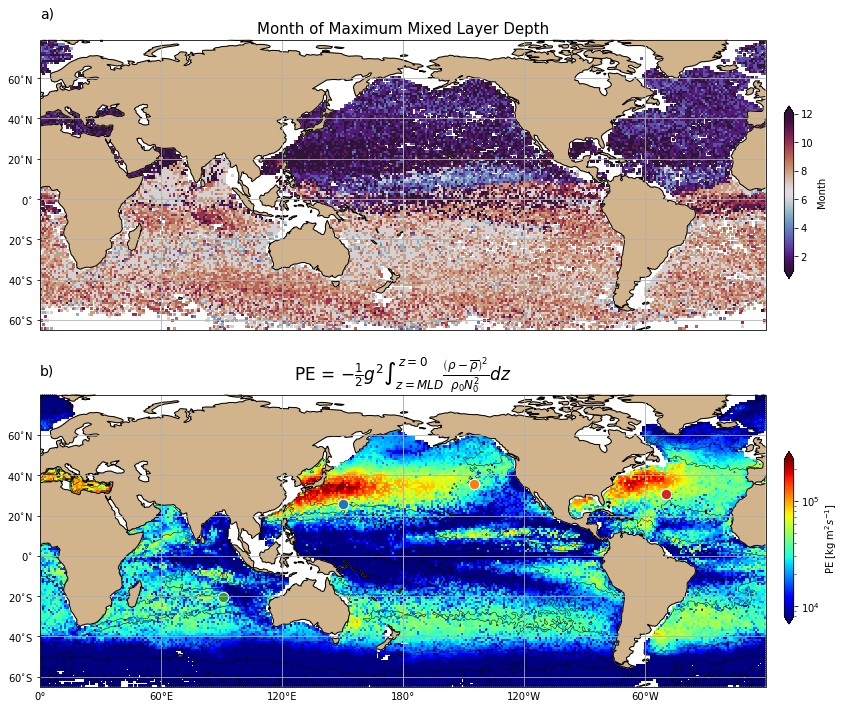

In [242]:
# ape_p = np.abs(np.nanmean(ape_rate[2:4,:,:],axis=0) - np.nanmean(ape_rate[6:8,:,:],axis=0)) # *np.nanmean(ape_rate,axis=0)
ape_p = ape_rate_max_month
ape_p_i = ape_rate_max_month_i
# pmin = 0.00001
# pmax = 0.004
pmin=0.1
pmax=5

# FIGURE  (map of seasonal change in APE rate)
f, (ax1,ax2) = plt.subplots(2,1,figsize=(13,12), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
# arg_d = xr.DataArray(data=ape_p, dims=['latitude', 'longitude'], coords=data_coords)
# arg_d_p = arg_d.plot(ax=ax1,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=0.00005, vmax=0.05),\
#                      cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False) # , norm=LogNorm(vmin=0.00001, vmax=0.005)
# for i in range(len(t_lon)):
#     ax1.scatter(t_lon[i], t_lat[i], s=110, transform=ccrs.PlateCarree(),zorder=2,edgecolors='w')
# ax1.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
# ax1.coastlines()
# ax1.set_title(r'Max PE conversion = $-\frac{1}{2} g \int_{z = -100m}^{z = 0} \kappa \frac{| \nabla_h \rho |^2}{\partial \overline{\rho} / \partial z} dz$',fontsize=15)
# cbpos = [0.92, 0.4, 0.01, 0.2]
# cax = f.add_axes(cbpos)
# cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', label='J/s/m$^2$')
# gl = ax1.gridlines(draw_labels=True)
# gl.xlabels_top = False
# gl.xlabels_bottom = False

# arg_d2 = xr.DataArray(data=ape_p_i, dims=['latitude', 'longitude'], coords=data_coords)
# arg_d2_p = arg_d2.plot(ax=ax0,transform=ccrs.PlateCarree(), vmin=0, vmax=12,\
#                      cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False) # , norm=LogNorm(vmin=0.00001, vmax=0.005)
# ax0.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
# ax0.coastlines()
# ax0.set_title(r'Month of Max Rate',fontsize=15)
# cbpos = [0.92, 0.13, 0.01, 0.2]
# cax = f.add_axes(cbpos)
# cb = f.colorbar(arg_d2_p, cax=cax, orientation='vertical', extend='both', label='Month')
# gl = ax0.gridlines(draw_labels=True)
# gl.xlabels_top = False

# month of max MLD 
mld_coords = {'latitude': mld_lat[25:-11], 'longitude': mld_lon}
arg_mld = xr.DataArray(data=mld_max_month[25:-11,:]+1, dims=['latitude', 'longitude'], coords=mld_coords)
arg_mld = arg_mld.plot(ax=ax1,transform=ccrs.PlateCarree(), vmin=1, vmax=12, \
                     cmap=plt.get_cmap('twilight_shifted'), zorder=0, add_colorbar=False)
ax1.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax1.coastlines()
# ax1.set_ylim([-65,65])
gl = ax1.gridlines(draw_labels=True)
ax1.set_title('Month of Maximum Mixed Layer Depth',fontsize=15)
gl.xlabels_top = False
gl.xlabels_bottom = False
cbpos = [0.92, 0.6, 0.01, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_mld, cax=cax, orientation='vertical', extend='both', label='Month')
gl.ylabels_left = True

# (map of max seasonal loc PE)
pe_levs = [8000, 250000] # 250000
# f, ax = plt.subplots(1,1,figsize=(10,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
arg_d = xr.DataArray(data=np.nanmax(pe_loc,axis=0), dims=['latitude', 'longitude'], coords=data_coords)
arg_d_p = arg_d.plot(ax=ax2,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1]), \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False)
ax2.contour(lon,lat,np.nanmean(pe,axis=0),\
           colors='k',transform=ccrs.PlateCarree(),levels=np.arange(pe_levs[0],pe_levs[1],75000),linewidths=0.5)
for i in range(len(t_lon)):
    ax2.scatter(t_lon[i], t_lat[i], s=110, transform=ccrs.PlateCarree(),zorder=2,edgecolors='w')
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax2.coastlines()
gl = ax2.gridlines(draw_labels=True)
ax2.set_title(r'PE = $-\frac{1}{2}g^2 \int_{z=MLD}^{z=0} \frac{\left( \rho - \overline{\rho} \right)^2}{\rho_0 N_0^2} dz$',fontsize=17)
gl.xlabels_top = False
cbpos = [0.92, 0.2, 0.01, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', label='PE [kg m$^2$$s^{-1}$]')
ax1.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax1.set_yticklabels(['60$^{\circ}$S', '40$^{\circ}$S', '20$^{\circ}$S', '0$^{\circ}$', '20$^{\circ}$N', '40$^{\circ}$N', '60$^{\circ}$N'])
ax2.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax2.set_yticklabels(['60$^{\circ}$S', '40$^{\circ}$S', '20$^{\circ}$S', '0$^{\circ}$', '20$^{\circ}$N', '40$^{\circ}$N', '60$^{\circ}$N'])
ax1.set_ylabel('')
ax2.set_ylabel('')
ax2.text(0, 90, 'b)', fontsize=14, transform=ccrs.PlateCarree())
ax1.text(0, 90, 'a)', fontsize=14, transform=ccrs.PlateCarree())
# ax0.text(0, 90, 'c)', fontsize=14, transform=ccrs.PlateCarree())
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_08_06/argo_mld_pe.jpg', dpi=550)

In [231]:
arg_d

<xarray.DataArray (latitude: 145, longitude: 360)>
array([[          nan, 2066.02897655,           nan, ..., 3065.37450847,
        1399.92678826, 1629.47894012],
       [2663.19308657, 1508.09760937, 1073.75901623, ..., 3194.47896003,
        1910.889318  , 2894.06378646],
       [          nan,           nan, 1063.6972291 , ...,           nan,
                  nan,           nan],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,    0.        ],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])
Coordinates:
  * latitude   (latitude) float32 -64.5 -63.5 -62.5 -61.5 ... 77.5 78.5 79.5
  * longitude  (longitude) float32 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5

In [136]:
# save file 
# -------------------------------
filename = ('/Users/jakesteinberg/Documents/CPT/Argo/Argo_PE_APE.nc')
ds = xr.Dataset(
    data_vars=dict(
        pe=(["month","lat","lon"], pe_loc),
        ape_rate=(["month","lat","lon"], ape_rate),
    ),
    coords=dict(
        month=(["month"], np.arange(0,12,1)),
        latitude=(["lat"], argo_s.LATITUDE.data),
        longitude=(["lon"], argo_s.LONGITUDE.data),
    ),
)
ds.to_netcdf(path=filename)

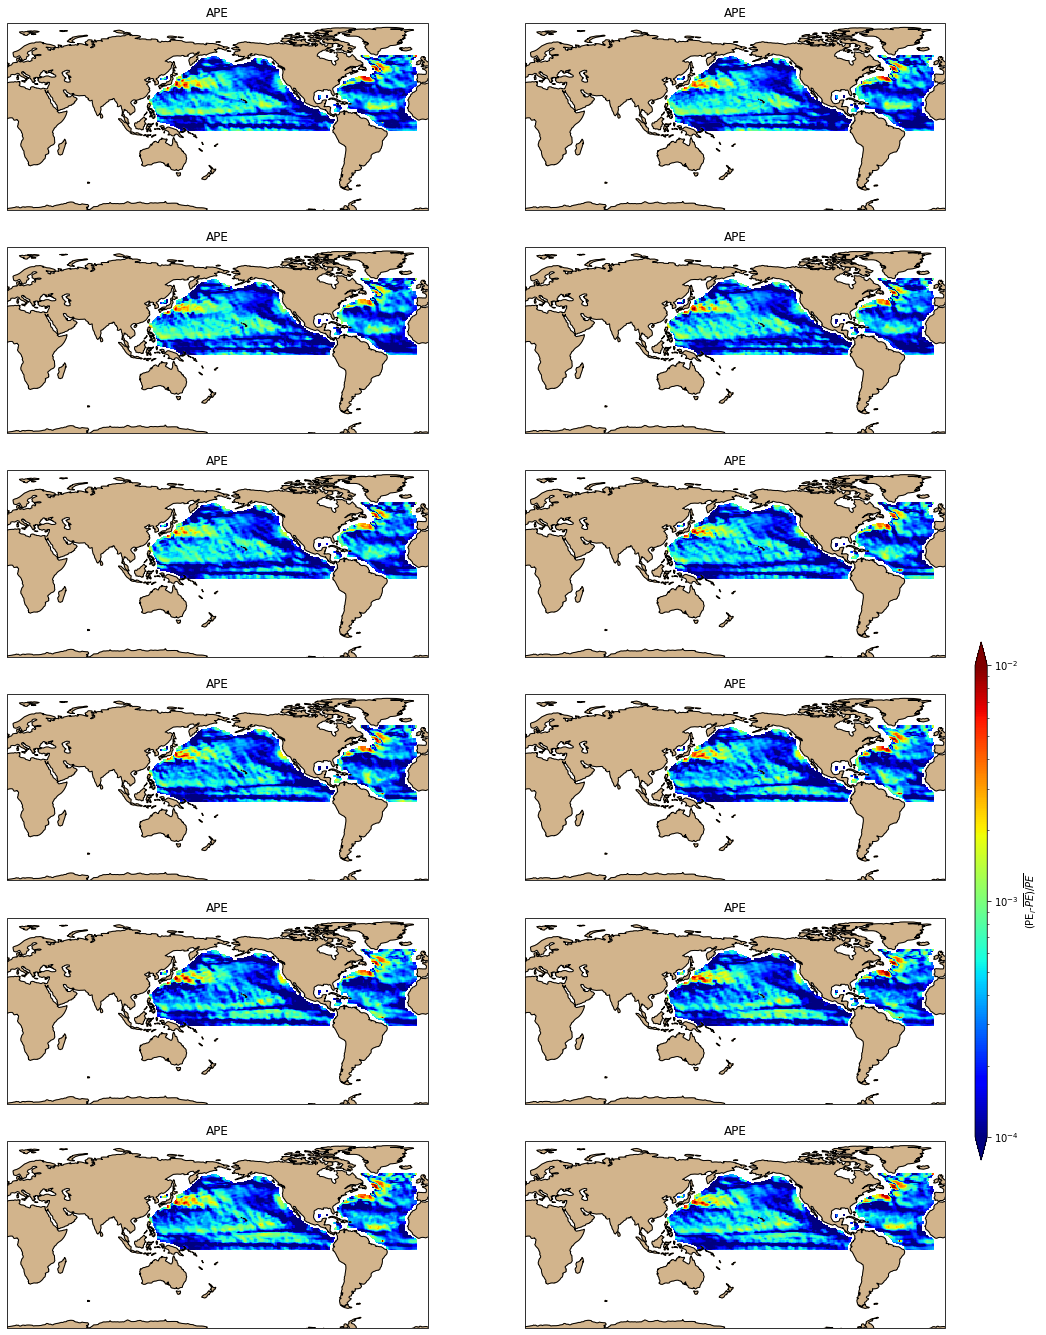

In [299]:
data_coords = {'latitude': lat, 'longitude': lon}
tcmap_2 = plt.get_cmap('jet')
f, ax = plt.subplots(6,2,figsize=(17,24), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
gax = ax.flatten()
for i in range(len(gax)):
    arg_d = xr.DataArray(data=ape_rate[i,:,:], dims=['latitude', 'longitude'], coords=data_coords)
    arg_d_p = arg_d.plot(ax=gax[i],transform=ccrs.PlateCarree(), norm=LogNorm(vmin=0.0001, vmax=0.01), \
                     cmap=tcmap_2, zorder=0, add_colorbar=False)

    gax[i].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    gax[i].coastlines()
    gax[i].set_title('APE')
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', \
                label='(PE$_i$-$\overline{PE}$)/$\overline{PE}$') # 'density at ' + str(A_s.PRESSURE[this_p].data) + ' dbar'
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_seasonal_pe.jpg', dpi=550)

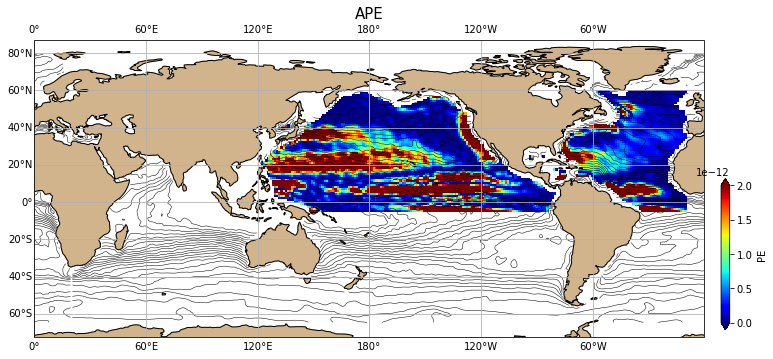

In [237]:
f, ax = plt.subplots(1,1,figsize=(12,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
arg_d = xr.DataArray(data=np.abs(gradx[0,:,:]+grady[0,:,:])**2, dims=['latitude', 'longitude'], coords=data_coords)
arg_d_p = arg_d.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=0, vmax=2e-12, \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False)
ax.contour(lon,lat,mean_den_r[0,:,:], colors='k',transform=ccrs.PlateCarree(),\
           levels=np.arange(22,28,0.25),linewidths=0.5) # np.nanmean(pe,axis=0)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title('APE',fontsize=15)
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', label='PE')

In [300]:
# seasonal swing
ape_frac_change = np.nan*np.ones((len(lat),len(lon)))
ape_tot_change = np.nan*np.ones((len(lat),len(lon)))
for i in tqdm(range(len(lat))):        
    for j in range(len(lon)): 
        # if np.nanmean(pe[:,i,j]) > 0.25*np.nanmean(pe):
        ape_tot_change[i,j] = np.abs((np.nanmax(ape_rate[:,i,j]) - np.nanmin(ape_rate[:,i,j]))) 
        ape_frac_change[i,j] = np.abs((np.nanmax(ape_rate[:,i,j]) - \
                                       np.nanmin(ape_rate[:,i,j])))/np.abs(np.nanmean(ape_rate[:,i,j]))

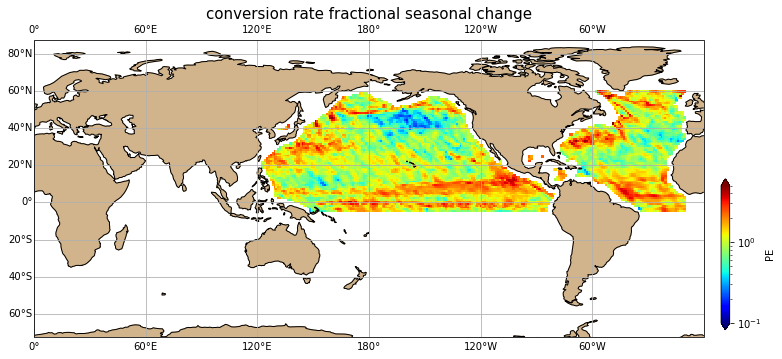

In [320]:
ape_p = ape_frac_change # *np.nanmean(ape_rate,axis=0)
# pmin = 0.00001
# pmax = 0.004
pmin=0.1
pmax=5
f, ax = plt.subplots(1,1,figsize=(12,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
arg_d = xr.DataArray(data=ape_p, dims=['latitude', 'longitude'], coords=data_coords)
arg_d_p = arg_d.plot(ax=ax,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=pmin, vmax=pmax), \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title('conversion rate fractional seasonal change',fontsize=15)
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', label='PE')

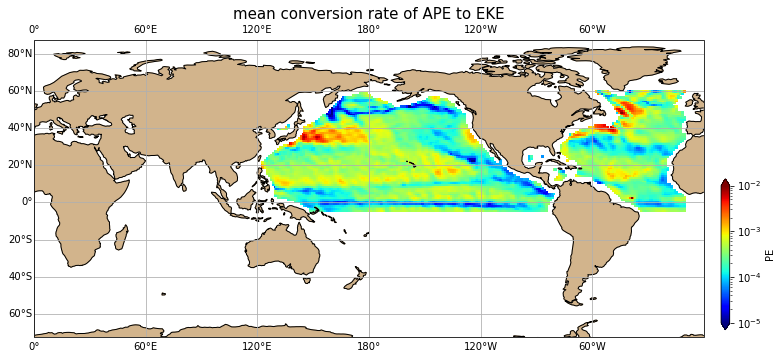

In [319]:
ape_p = np.nanmean(ape_rate,axis=0) # *np.nanmean(ape_rate,axis=0)
# pmin = 0.00001
# pmax = 0.004
pmin=0.1
pmax=5
f, ax = plt.subplots(1,1,figsize=(12,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
arg_d = xr.DataArray(data=ape_p, dims=['latitude', 'longitude'], coords=data_coords)
arg_d_p = arg_d.plot(ax=ax,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=0.00001, vmax=0.01), \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title('mean conversion rate of APE to EKE',fontsize=15)
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', label='PE')

In [69]:
np.interp?

In [70]:
np.polyfit?